# Car Resale Marketplace Data Mining Project
#### Project Advisor: Prof. Arindam Ray
#### Team Name: Beta Busters
#### Team Members: 
1. Amolika Godse 
2. Anuraag Gujje 
3. Ganesh Talluri 
4. Sai Sudheer Vishnumolakala 
5. Suraj Shiva Kumar


### Problem Statement

We propose a data mining project to create a car resale marketplace that enables users to sell and buy resale cars. The key objectives of this project are as follows:

1. Predict the resale price of cars based on their features, helping sellers set competitive prices.

2. Recommend similar cars to potential buyers based on their preferences.


### A) Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

### B) Data Loading & Checks

In [2]:
df = pd.read_excel('data/master_data.xlsx')

In [3]:
df.head()

,price,type,make,year,model,mileage_miles,Exterior Color,Interior Color,Body Style,Doors,...,Lane Assist,Parking Assist System,Stability Control,Adaptive Cruise Control,Alloy Wheels,Cooled Seats,Full Self-Driving Capability,Third Row Seating,Tow Hitch / Package,Rear Seat Entertainment
0,32589,sedan,subaru,2022.0,wrx,14172.0,White,Black,Sedan,4 Doors,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32589,sedan,audi,2022.0,a3,7729.0,Silver,Black,Sedan,4 Doors,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48589,sedan,bmw,2023.0,5 series,25001.0,Blue,Brown,Sedan,4 Doors,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24589,sedan,hyundai,2023.0,elantra,8677.0,Red,Gray,Sedan,4 Doors,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23999,sedan,hyundai,2023.0,elantra,16506.0,Blue,Black,Sedan,4 Doors,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(2897, 50)

### C) Data Cleaning

In [5]:
df.columns = [col.lower().replace(' / ','_').replace(' ', '_').strip() for col in df.columns]

In [6]:
df.columns

Index(['price', 'type', 'make', 'year', 'model', 'mileage_miles',
       'exterior_color', 'interior_color', 'body_style', 'doors', 'mpg', 'vin',
       'engine', 'transmission', 'drive_type', 'fuel', 'tank_size',
       'bed_style', 'cab_style', 'android_auto', 'apple_carplay',
       'backup_camera_assist', 'bluetooth', 'heated_seats',
       'hill_assist_system', 'keyless_entry', 'keyless_ignition',
       'multimedia_telematics', 'premium_sound_system', 'satellite_radio',
       'sunroof_moonroof', 'leather_seats', 'power_seats', 'traction_control',
       'driver_assistance_confidence_pkg', 'head-up_display',
       'lane_departure_warning', 'navigation_system', 'remote_start',
       'blind_spot_monitor', 'lane_assist', 'parking_assist_system',
       'stability_control', 'adaptive_cruise_control', 'alloy_wheels',
       'cooled_seats', 'full_self-driving_capability', 'third_row_seating',
       'tow_hitch_package', 'rear_seat_entertainment'],
      dtype='object')

In [7]:
# Check Duplicates
df.duplicated().sum()

9

In [8]:
# Remove Duplicates
df = df.drop_duplicates()
df.shape

(2888, 50)

In [9]:
# Convert the entire DataFrame to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [10]:
# check Missing value
df.isnull().sum()

price                                  0
type                                   0
make                                   1
year                                   1
model                                  1
mileage_miles                          1
exterior_color                         4
interior_color                        16
body_style                             1
doors                                  1
mpg                                    1
vin                                    1
engine                                 1
transmission                           1
drive_type                             1
fuel                                   1
tank_size                           1962
bed_style                           2644
cab_style                           2534
android_auto                        1536
apple_carplay                       1471
backup_camera_assist                  71
bluetooth                           1058
heated_seats                        1208
hill_assist_syst

In [11]:
# Checking type and bodystyle columns
print(f"Unique values in type: {df['type'].unique()}")
print(f"Unique values in body_style: {df['body_style'].unique()}")

Unique values in type: ['sedan' 'supuv' 'wagon' 'coupe' 'minivan' 'pickups' 'hatchback'
 'convertible']
Unique values in body_style: ['sedan' 'suv' 'wagon' 'coupe' 'minivan' 'pickup' nan 'hatchback'
 'convertible']


In [12]:
# Dropping this column as this is similar to type column
df = df.drop('body_style',axis=1)

In [13]:
df = df.dropna(subset=['make'])

In [14]:
df = df.drop('android_auto',axis=1)

In [15]:
df = df.drop(columns=['exterior_color', 'interior_color', 'tank_size', 'bed_style', 'cab_style', 'vin'],axis=1)

In [16]:
# Split the "mpg" column and extract city_mpg and hwy_mpg
df[['city_mpg', 'hwy_mpg']] = df['mpg'].str.split(' / ', expand=True)

# Convert the new columns to integers
df['city_mpg'] = df['city_mpg'].str.extract('(\d+)').astype(float).fillna(0).astype(int)
df['hwy_mpg'] = df['hwy_mpg'].str.extract('(\d+)').astype(float).fillna(0).astype(int)

df = df.drop(columns=['mpg'])

In [17]:
df[['city_mpg','hwy_mpg']].corr()

,city_mpg,hwy_mpg
city_mpg,1.000000,0.936509
hwy_mpg,0.936509,1.000000


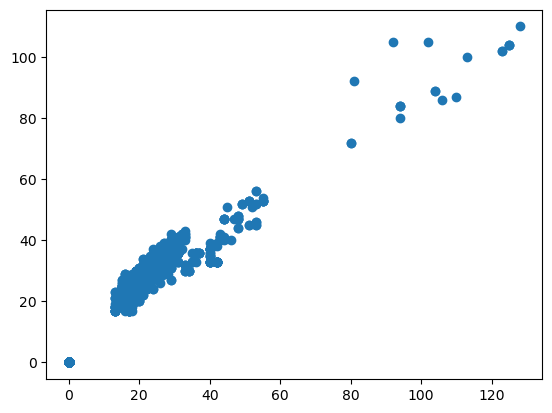

In [18]:
plt.scatter(df['city_mpg'],df['hwy_mpg'])

In [19]:
df['avg_mpg'] = (df['city_mpg'] + df['hwy_mpg'])/2

df = df.drop(columns=['city_mpg','hwy_mpg'])

In [20]:
df['doors'] = df['doors'].str.replace('doors', '').str.strip()
df['doors'].value_counts()

doors
4    2645
2     239
3       3
Name: count, dtype: int64

In [21]:
df = df.rename(columns={'mileage_miles': 'miles_driven'})

### D) Data preprocessing

In [22]:
num_features = ['miles_driven', 'avg_mpg']
cat_features_label = ['type', 'make', 'model', 'transmission', 'drive_type', 'fuel', 'engine']
cat_features_ordinal = ['year', 'doors']
luxury = ['lux_category']

In [23]:
bin_features = ['apple_carplay', 'backup_camera_assist', 'bluetooth', 'heated_seats',
                'hill_assist_system', 'keyless_entry', 'keyless_ignition', 'multimedia_telematics', 'premium_sound_system',
                'satellite_radio', 'sunroof_moonroof', 'leather_seats', 'power_seats', 'traction_control',
                'driver_assistance_confidence_pkg', 'head-up_display', 'lane_departure_warning', 'navigation_system',
                'remote_start', 'blind_spot_monitor', 'lane_assist', 'parking_assist_system', 'stability_control', 
                'adaptive_cruise_control', 'alloy_wheels', 'cooled_seats', 'full_self-driving_capability',
                'third_row_seating', 'tow_hitch_package', 'rear_seat_entertainment']

In [24]:
# Replace all NaN values in binary features with 0
df[bin_features] = df[bin_features].fillna(0)

In [25]:
df['bin_sum'] = df[bin_features].sum(axis=1)

In [26]:
df[['bin_sum']].describe()

,bin_sum
count,2887.000000
mean,9.256321
std,2.580265
min,1.000000
25%,7.000000
50%,11.000000
75%,11.000000
max,12.000000


In [27]:
# Define a function to map values to categories
def categorize(value):
    if value >= 11:
        return 1
    else:
        return 0

In [28]:
# Apply the categorization function to create a new 'category' column
df['lux_category'] = df['bin_sum'].apply(categorize)

In [29]:
df['lux_category'].value_counts()

lux_category
1    1464
0    1423
Name: count, dtype: int64

In [30]:
# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat_label', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_features_label),
        ('cat_ordinal', OrdinalEncoder(), cat_features_ordinal),
        ('binary', 'passthrough', luxury)])

### Exploratory Data Analysis

In [31]:
!pip install --upgrade seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


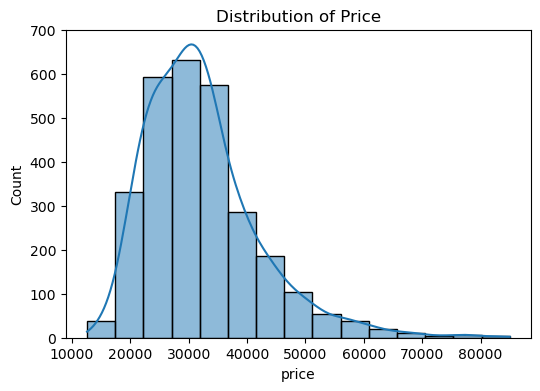

In [32]:
# Price Distribution
plt.figure(figsize=(6, 4))
sns.histplot(data=df['price'], bins=15, kde=True)
plt.title('Distribution of Price')
plt.show()

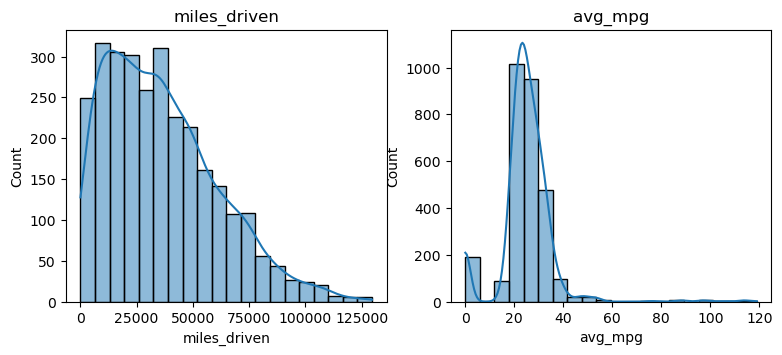

In [33]:
# Distribution of Numerical Features
plt.figure(figsize=(24, 12))
for feature in num_features:
    plt.subplot(3, 5, num_features.index(feature) + 1)
    sns.histplot(data=df[feature], bins=20, kde=True)
    plt.title(feature)
plt.show()

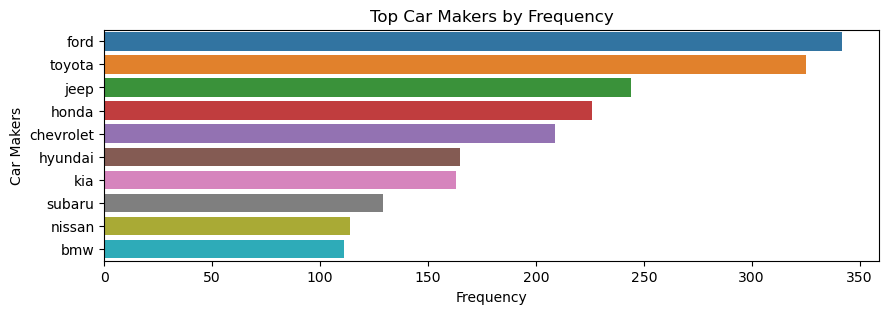

In [34]:
#Top car makers by frequency
n = 10
top_makers = df['make'].value_counts().head(n)

plt.figure(figsize=(10, 3))
sns.barplot(x=top_makers.values, y=top_makers.index)
plt.xlabel('Frequency')
plt.ylabel('Car Makers')
plt.title(f'Top Car Makers by Frequency')
plt.show()

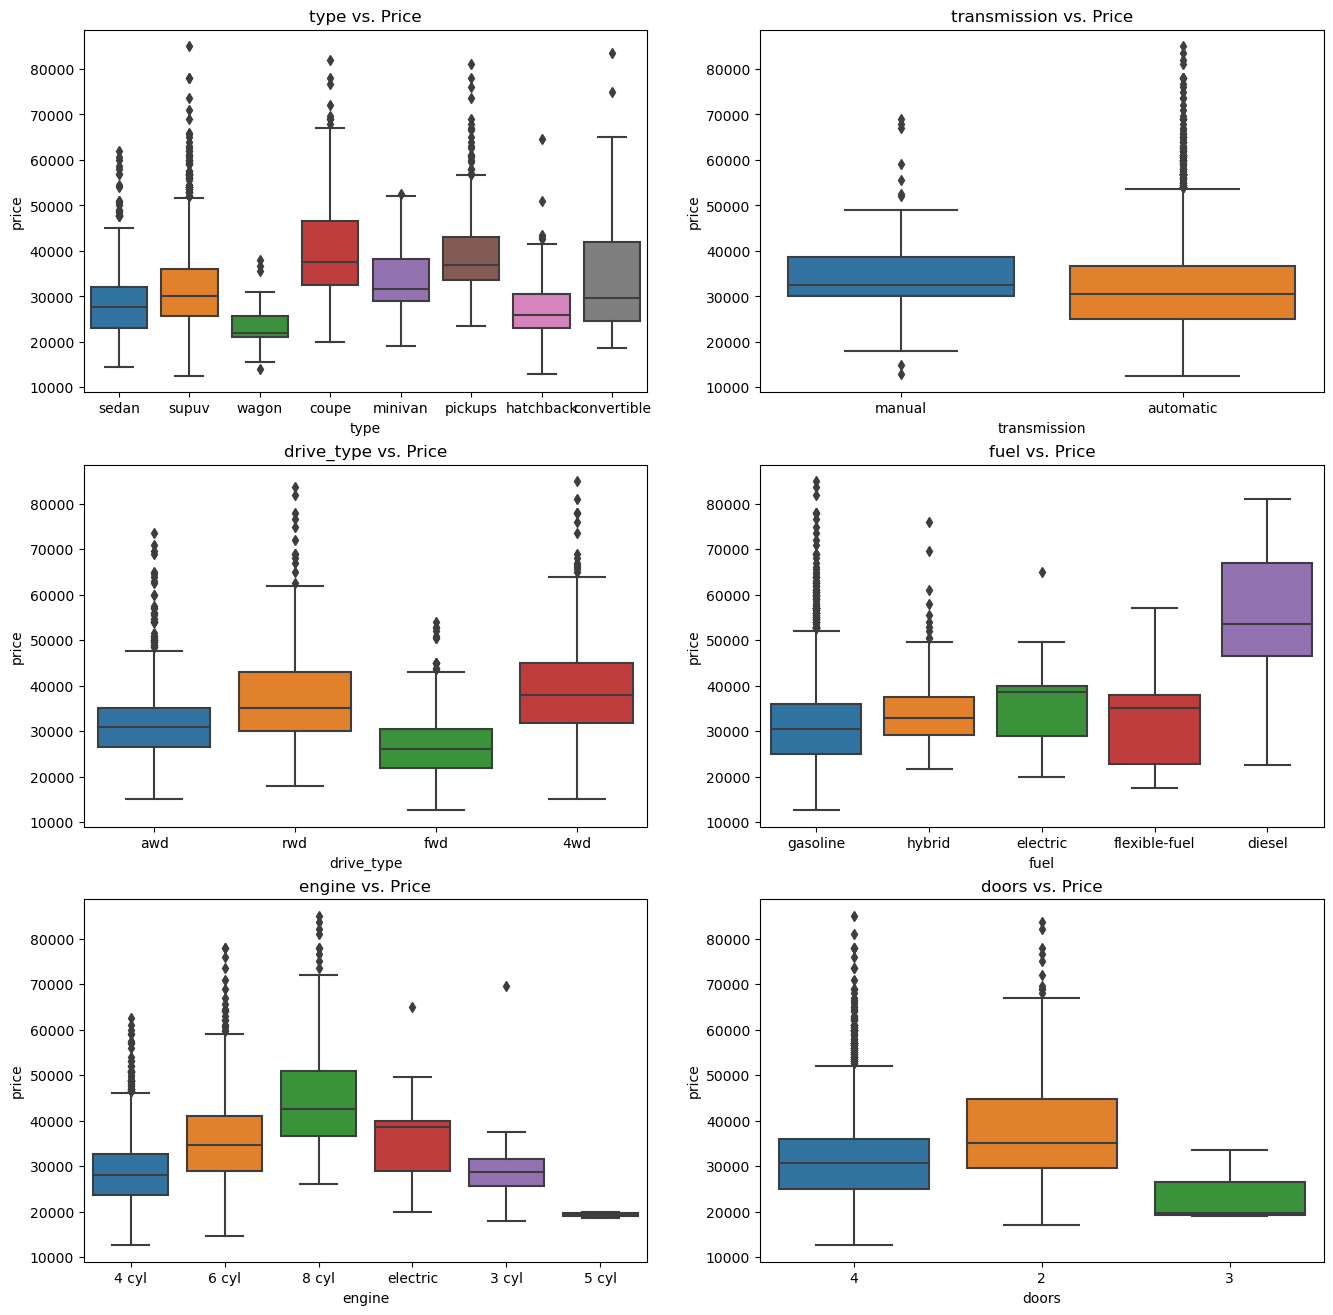

In [35]:
# Categorical Features vs Price BoxPlots
cat_cols = ['type', 'transmission', 'drive_type', 'fuel', 'engine', 'doors']

plt.figure(figsize=(16, 16))
for feature in cat_cols:
    plt.subplot(3, 2, cat_cols.index(feature) + 1)
    sns.boxplot(data=df, x=feature, y='price')
    plt.title(f'{feature} vs. Price')
plt.show()

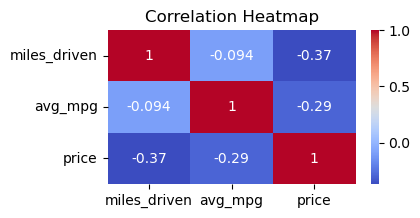

In [36]:
# Correlation Analysis
correlation_matrix = df[num_features + ['price']].corr()
plt.figure(figsize=(4, 2))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### E) Train & Test Split

In [37]:
# Split the data into features (X) and target (y)
X = df.drop(columns=bin_features)
X = X.drop(columns=['bin_sum','price'])
y = df['price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
import statsmodels.api as sm

In [39]:
X_trans  = preprocessor.fit_transform(X)

In [40]:
df.groupby('make')['model'].nunique()

make
acura          6
alfa           2
audi          18
bmw           15
buick          7
cadillac      10
chevrolet     19
chrysler       3
dodge          6
fiat           2
ford          20
genesis        5
gmc            7
honda         11
hyundai       14
infiniti       6
jaguar         4
jeep           9
kia           15
land           2
lexus         10
lincoln        9
mazda          7
mercedes      14
mini           2
mitsubishi     3
nissan        12
polestar       1
porsche        2
ram            3
subaru         7
tesla          3
toyota        19
volkswagen     9
volvo          6
Name: model, dtype: int64

In [41]:
df.groupby(['model'])['price'].max()

model
124 spider    27999
1500          56999
2             40999
2 series      38999
200           18589
              ...  
xt6           53999
xts           21589
yukon         63999
yukon xl      46589
z4            52589
Name: price, Length: 288, dtype: int64

In [42]:
X_with_const = sm.add_constant(X_trans)

# Fit OLS regression model
model = sm.OLS(y, X_with_const).fit()

# Print regression summary
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     53.10
Date:                Mon, 06 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:56:21   Log-Likelihood:                -27774.
No. Observations:                2887   AIC:                         5.616e+04
Df Residuals:                    2579   BIC:                         5.800e+04
Df Model:                         307                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8365.0418    422.571     19.796      0.0

### F) Model Fitting

#### Random Forest Regressor

In [43]:
rf_model = RandomForestRegressor(random_state=42)

# Create the full pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

In [44]:
# Fit the pipeline on the training data
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['lux_category'])])),
                ('model', RandomForestRegressor(random_state=42))])

#### MLP Regressor

In [45]:
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', mlp_model)
])

In [46]:
mlp_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['lux_category'])])),
                ('model',
                 MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000,
                              random_state=42))])

#### Gradient Boosting Regressor

In [47]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', gb_model)
])

In [48]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['lux_category'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

#### Voting Regressor ( ENSEMBLE )

In [49]:
voting_model = VotingRegressor(estimators=[('rf', rf_model), ('mlp', mlp_model)])

# Create the full pipeline (if needed)
voting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', voting_model)  
])

In [50]:
voting_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['lux_category'])])),
                ('model',
                 VotingRegressor(estimators=[('rf',
                                              RandomForestRegressor(random_state=42)),
                                             ('mlp',
                                              MLPRegressor(hidden_layer_sizes=(100,
                                                                               50),
                                                           max_iter=1000,
                                                           random_state=42))]))])

#### Stacking Regressor ( ENSEMBLE )

In [51]:
stacking_model = StackingRegressor(
    estimators=[('rf', rf_model), ('mlp', mlp_model)],
    final_estimator=MLPRegressor()  # Choose a meta-regressor (e.g., RandomForestRegressor)
)

# Create the full pipeline (if needed)
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', stacking_model)  
])

In [52]:
stacking_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['miles_driven', 'avg_mpg']),
                                                 ('cat_label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type', 'make', 'model',
                                                   'transmission', 'drive_type',
                                                   'fuel', 'engine']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['year', 'doors']),
                                                 ('binary', 'passthrough',
                                                  ['lux_category'])])),
                ('model',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(random_state=42)),
                                               ('mlp',
                                                MLPRegressor(hidden_layer_sizes=(100,
                                                                                 50),
                                                             max_iter=1000,
                                                             random_state=42))],
                                   final_estimator=MLPRegressor()))])

#### Storing in Pickle Files

In [53]:
with open('rf_pipeline.pkl', 'wb') as file:
    pickle.dump(rf_pipeline, file)
with open('mlp_pipeline.pkl', 'wb') as file:
    pickle.dump(mlp_pipeline, file)
with open('voting_pipeline.pkl', 'wb') as file:
    pickle.dump(voting_pipeline, file)
with open('stacking_pipeline.pkl', 'wb') as file:
    pickle.dump(stacking_pipeline, file)

In [54]:
# with open('mlp_pipeline.pkl', 'rb') as file:
#     loaded_pipeline = pickle.load(file)

# # Use the loaded pipeline for predictions
# y_pred_rf = loaded_pipeline.predict(X_test)

### G) Model Prediction

In [55]:
# Make predictions on the test data
y_pred_rf = rf_pipeline.predict(X_test)

# Calculate the model's performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print(f"Prediction using Random Forest Regressor")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (R2): {r2}")

Prediction using Random Forest Regressor
Root Mean Squared Error: 4183.586446221756
R-squared (R2): 0.8133946338015013


In [56]:
# Make predictions on the test data
y_pred_mlp = mlp_pipeline.predict(X_test)

# Calculate the model's performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2 = r2_score(y_test, y_pred_mlp)

print(f"Prediction using MLP Regressor")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (R2): {r2}")

Prediction using MLP Regressor
Root Mean Squared Error: 4098.1316545684695
R-squared (R2): 0.8209400551617841


In [57]:
# Make predictions on the test data
y_pred_gb = gb_pipeline.predict(X_test)

# Calculate the model's performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2 = r2_score(y_test, y_pred_gb)

print(f"Prediction using Gradient Boosting Regressor")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (R2): {r2}")

Prediction using Gradient Boosting Regressor
Root Mean Squared Error: 4737.358808056344
R-squared (R2): 0.7607239708264534


In [58]:
y_pred = (y_pred_rf + y_pred_mlp)/2

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (R2): {r2}")

Root Mean Squared Error: 3818.0282512009135
R-squared (R2): 0.8445807141249889


In [59]:
# Make predictions on the test data
y_pred_voting = voting_pipeline.predict(X_test)

# Calculate the model's performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_voting))
r2 = r2_score(y_test, y_pred_voting)

print(f"Prediction using Voting Regressor")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (R2): {r2}")

Prediction using Voting Regressor
Root Mean Squared Error: 3818.0282512009135
R-squared (R2): 0.8445807141249889


In [60]:
# Make predictions on the test data
y_pred_stacking = stacking_pipeline.predict(X_test)

# Calculate the model's performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
r2 = r2_score(y_test, y_pred_stacking)

print(f"Prediction using Stacking Regressor")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (R2): {r2}")

Prediction using Stacking Regressor
Root Mean Squared Error: 3811.543602443319
R-squared (R2): 0.8451082029443768


In [61]:
# Get feature importances
name = []
imp = []

for n,i in zip(X,rf_model.feature_importances_):
    name.append(n)
    imp.append(round(i*100,2))

features = pd.DataFrame({'Features':name ,'Importance':imp})
features.sort_values(by='Importance',ascending=False).head(15)

,Features,Importance
1,make,27.74
0,type,18.80
6,engine,0.66
8,drive_type,0.56
7,transmission,0.21
2,year,0.20
5,doors,0.20
3,model,0.18
4,miles_driven,0.18
10,avg_mpg,0.11


In [62]:
# Combine X_test, y_test, and y_pred into a single DataFrame
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_voting
})

# Print the results_df
results_df.to_csv('output.csv')

In [63]:
# def rmse(y_test, y_pred):
#     mse = mean_squared_error(y_test, y_pred)
#     return np.sqrt(mse)

In [64]:
# rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [65]:
# rf_param_dist = {
#     'model__n_estimators': [50, 100, 150, 200],
#     'model__max_features': ['sqrt', 'log2', None],
#     'model__max_depth': [10, 20, 30, 40, 50, None],
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4],
# }

In [66]:
# rf_random_search = RandomizedSearchCV(rf_pipeline, param_distributions=rf_param_dist, n_iter=100,
#                                    scoring=rmse_scorer, n_jobs=-1, 
#                                    cv=3, random_state=100)
# rf_random_search.fit(X_train, y_train)

In [67]:
# # Make predictions on the test data
# y_pred = rf_random_search.predict(X_test)

# # Calculate the model's performance metrics
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)

# print(f"Root Mean Squared Error: {rmse}")
# print(f"R-squared (R2): {r2}")

In [68]:
num_features = ['mileage_miles', 'city_mpg', 'hwy_mpg']
cat_features_label = ['type', 'make', 'model', 'transmission', 'drive_type', 'fuel', 'engine']
cat_features_ordinal = ['year', 'doors']
bin_features = ['android_auto', 'apple_carplay', 'backup_camera_assist', 'bluetooth', 'heated_seats',
                'hill_assist_system', 'keyless_entry', 'keyless_ignition', 'multimedia_telematics', 'premium_sound_system',
                'satellite_radio', 'sunroof_moonroof', 'leather_seats', 'power_seats', 'traction_control',
                'driver_assistance_confidence_pkg', 'head-up_display', 'lane_departure_warning', 'navigation_system',
                'remote_start', 'blind_spot_monitor', 'lane_assist', 'parking_assist_system', 'stability_control', 
                'adaptive_cruise_control', 'alloy_wheels', 'cooled_seats', 'full_self-driving_capability',
                'third_row_seating', 'tow_hitch_package', 'rear_seat_entertainment']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat_label', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_features_label),
        ('cat_ordinal', OrdinalEncoder(), cat_features_ordinal),
        ('binary', 'passthrough', bin_features)])

Root Mean Squared Error: 3545.000065033697
R-squared (R2): 0.8660140904089552